In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import io
import zipfile

file_path = '/content/drive/MyDrive/C23-PR521/dataset/kualitas_buah.zip'

zip_ref = zipfile.ZipFile(file_path, 'r')
zip_ref.extractall('/content/dataset/kualitas_buah')
zip_ref.close()

In [3]:
train_dir = '/content/dataset/kualitas_buah/train'
val_dir = '/content/dataset/kualitas_buah/val'
test_dir = '/content/dataset/kualitas_buah/test'

In [4]:
batch_size = 32
img_width = 224
img_height = 224
input_shape = (img_width, img_height, 3)

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

augmented_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

normal_datagen = ImageDataGenerator(
    rescale=1./255
)

train_data = augmented_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

val_data = normal_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

test_data = normal_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 5988 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 500 images belonging to 10 classes.


In [6]:
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(
    include_top=False, 
    weights='imagenet', 
    input_shape=input_shape
)

for layer in base_model.layers:
  layer.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(train_data.num_classes, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1

In [8]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

In [10]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
188/188 [==============================] - 404s 2s/step - loss: 0.4544 - accuracy: 0.8437 - val_loss: 0.1752 - val_accuracy: 0.9480
Epoch 2/100
188/188 [==============================] - 410s 2s/step - loss: 0.1484 - accuracy: 0.9527 - val_loss: 0.0969 - val_accuracy: 0.9680
Epoch 3/100
188/188 [==============================] - 408s 2s/step - loss: 0.0835 - accuracy: 0.9755 - val_loss: 0.0919 - val_accuracy: 0.9720
Epoch 4/100
188/188 [==============================] - 400s 2s/step - loss: 0.0845 - accuracy: 0.9714 - val_loss: 0.0618 - val_accuracy: 0.9820
Epoch 5/100
188/188 [==============================] - 400s 2s/step - loss: 0.0580 - accuracy: 0.9806 - val_loss: 0.0522 - val_accuracy: 0.9840
Epoch 6/100
188/188 [==============================] - 398s 2s/step - loss: 0.0701 - accuracy: 0.9780 - val_loss: 0.0557 - val_accuracy: 0.9750
Epoch 7/100
188/188 [==============================] - 397s 2s/step - loss: 0.0482 - accuracy: 0.9836 - val_loss: 0.0223 - val_accuracy:

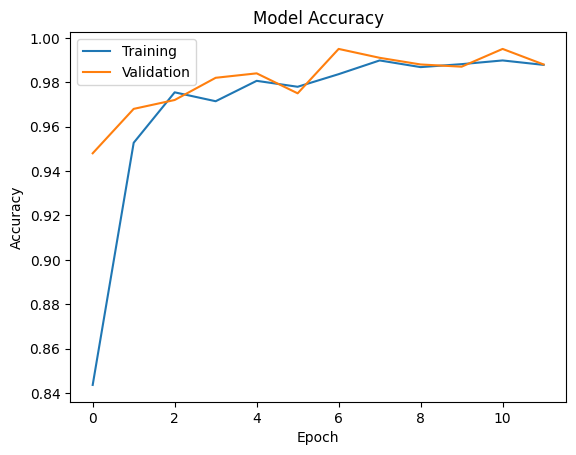

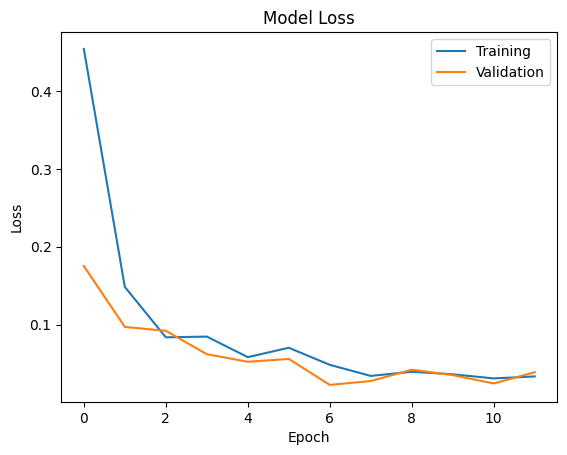

In [11]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [12]:
scores = model.evaluate(test_data)

print('Akurasi: %.2f%%' % (scores[1] * 100))

16/16 [==============================] - 22s 1s/step - loss: 0.0351 - accuracy: 0.9940
Akurasi: 99.40%


In [13]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

y_pred = np.argmax(model.predict(test_data), axis=1)
y_true = test_data.classes

cm = confusion_matrix(y_true, y_pred)
cr = classification_report(y_true, y_pred, target_names=test_data.class_indices.keys())

16/16 [==============================] - 38s 2s/step


In [14]:
print(cm)

[[50  0  0  0  0  0  0  0  0  0]
 [ 1 49  0  0  0  0  0  0  0  0]
 [ 0  0 49  0  1  0  0  0  0  0]
 [ 0  0  0 50  0  0  0  0  0  0]
 [ 0  0  0  0 50  0  0  0  0  0]
 [ 0  0  0  0  0 50  0  0  0  0]
 [ 0  0  0  0  0  0 49  1  0  0]
 [ 0  0  0  0  0  0  0 50  0  0]
 [ 0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0  0 50]]


In [15]:
print(cr)

                precision    recall  f1-score   support

    Apel Busuk       0.98      1.00      0.99        50
    Apel Segar       1.00      0.98      0.99        50
   Jeruk Busuk       1.00      0.98      0.99        50
   Jeruk Segar       1.00      1.00      1.00        50
  Mangga Busuk       0.98      1.00      0.99        50
  Mangga Segar       1.00      1.00      1.00        50
  Pisang Busuk       1.00      0.98      0.99        50
  Pisang Segar       0.98      1.00      0.99        50
Stroberi Busuk       1.00      1.00      1.00        50
Stroberi Segar       1.00      1.00      1.00        50

      accuracy                           0.99       500
     macro avg       0.99      0.99      0.99       500
  weighted avg       0.99      0.99      0.99       500



Saving test3.jpg to test3.jpg
1/1 [==============================] - 0s 53ms/step


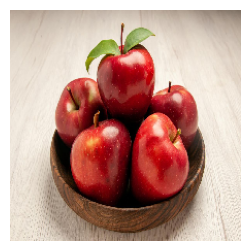

test3.jpg is a apel segar

[2.7844042e-02 9.6385676e-01 2.4243200e-05 5.5718665e-05 6.7469693e-05
 6.1065788e-05 2.2142460e-03 2.4864224e-03 4.8625990e-04 2.9037262e-03]
[2.78, 96.39, 0.0, 0.01, 0.01, 0.01, 0.22, 0.25, 0.05, 0.29]


In [29]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  img = tf.keras.utils.load_img(fn, target_size=(224, 224))
  x = tf.keras.utils.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = x/255.0

  images = np.vstack([x])
  classes = model.predict(images, batch_size=32)
  if classes[0][0]>0.5:
    prediction = 'apel busuk'
  elif classes[0][1]>0.5:
    prediction = 'apel segar'
  elif classes[0][2]>0.5:
    prediction = 'jeruk busuk'
  elif classes[0][3]>0.5:
    prediction = 'jeruk segar'
  elif classes[0][4]>0.5:
    prediction = 'mangga busuk'
  elif classes[0][5]>0.5:
    prediction = 'mangga segar'
  elif classes[0][6]>0.5:
    prediction = 'pisang busuk'
  elif classes[0][7]>0.5:
    prediction = 'pisang segar'
  elif classes[0][8]>0.5:
    prediction = 'stroberi busuk'
  elif classes[0][9]>0.5:
    prediction = 'stroberi segar'

  plt.figure(figsize=(3,3))
  plt.imshow(tf.keras.utils.load_img(fn, color_mode="rgb", target_size=(224, 224), interpolation="nearest"))

  plt.axis('off')
plt.show()
print('{} is a {}'.format(fn,prediction))
print()
print(classes[0])
print([float(np.round(x * 100, 2)) for x in classes[0]])